In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
import os
import Parameters as param
import sys
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend/')
import Gillespie_backend as gil
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Analysis/')
import Simulate as Sim

from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=100, stretch=LogStretch())
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y,nrows=1,ncols=1,pos=1,dpi=75,norm=None,colorbar=True,cmap=white_viridis,ax=None):
    if ax is None:
        ax = fig.add_subplot(nrows, ncols, pos, projection='scatter_density')
    if norm is None:
        density = ax.scatter_density(x, y, cmap=cmap,dpi=dpi)
    else:
        density = ax.scatter_density(x, y, cmap=cmap,dpi=dpi,norm=norm)
    if colorbar:
        fig.colorbar(density, label='Number of points per pixel')
    return ax

from matplotlib.colors import ListedColormap
cmap = plt.cm.Blues
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)
cmap = plt.cm.Purples
my_cmap_P = cmap(np.arange(cmap.N))
my_cmap_P[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap_P = ListedColormap(my_cmap_P)

## Summarize of this document :
Here we look at the value of the entropy of the system and its correlation with the average distance of the linkers from [0,0,0].
We observe that the smaller is the average distance : the bigger the entropy is

In [2]:
Nlinker = 10
ell_tot = 10**3
#kdiff = Nlinker/ (4/3 * np.pi * (ell_tot /2)**1.5)
V = ((ell_tot/6)**1.5/Nlinker**0.5*3/4*np.pi)
#V = 4/3*np.pi*(ell_tot/6)**1.5
kdiff = 5/V
Energy = -15
seeds = [np.random.randint(0,1000000) for _ in range(10)]
print('critical energy : '+str(1.5*np.log(ell_tot/Nlinker*(np.pi/3))))

step_tot = 10**5
dump_step = 10**3
measurement_step = 10**2

critical energy : 6.976931674754073


In [3]:
def nonzero_points(arr):
    """Returns all points in `arr` that are not equal to [0, 0, 0].
    
    Args:
        arr (numpy.ndarray): A 2D or 3D array of shape (Lx, N, 3) or (N, 3)
    
    Returns:
        numpy.ndarray: A 2D array of shape (M, 3) where M is the number of non-zero points in `arr`
    """
    arr = np.atleast_2d(arr)
    nonzero_mask = np.any(arr != [0,0,0], axis=1)
    nonzero_indices = np.argwhere(nonzero_mask)
    nonzero_points = arr[nonzero_mask]
    result = nonzero_points.reshape((-1, 3))
    return result



import numpy as np

def linker_entropy(move, S):
    """
    This function takes two arrays 'move' and 'S' as input and returns a dictionary. The keys in the dictionary
    represent the number of bound linkers, and the values are 2D NumPy arrays containing the corresponding
    entropy values and their indices in the input array 'S'.
    
    Parameters:
    - move (list): An array where each entry is an integer between 0 and 3 (inclusive). A value of 3 represents
                   a linker binding, while a value of 0 represents a linker unbinding. Values 1 and 2 indicate
                   no change in the number of bound linkers.
    - S (list): An array containing the entropy of the system at each step in 'move'.
    
    Returns:
    - entropy_dict (dict): A dictionary where each key represents the number of bound linkers and the corresponding
                           value is a 2D NumPy array. Each row of the array contains the entropy for that number of bound linkers
                           and the index of the entropy value in the input array 'S'.
    """
    entropy_dict = {}
    bound_linkers = 0

    for i in range(len(move)):
        if move[i] == 3:
            bound_linkers += 1
        elif move[i] == 0:
            bound_linkers -= 1
            if bound_linkers < 0:
                bound_linkers = 0

        if bound_linkers not in entropy_dict:
            entropy_dict[bound_linkers] = []

        entropy_dict[bound_linkers].append((S[i], i))

    for key in entropy_dict:
        entropy_dict[key] = np.array(entropy_dict[key])

    return entropy_dict



In [17]:
Gil = gil.Gillespie(ell_tot=ell_tot,rho0=0.,BindingEnergy=Energy,kdiff=kdiff,seed=19874,sliding=False,Nlinker=10,old_gillespie=None,dimension=1)

In [18]:
R = np.zeros((step_tot,9,3),dtype=float)
S = np.zeros((step_tot),dtype=float)
moves = np.zeros((step_tot),dtype=float)
for step in range(step_tot):
    move,time = Gil.evolve()
    moves[step] = move
    R[step] = nonzero_points(Gil.get_r())
    S[step] = Gil.get_S()

In [19]:
S -= ell_tot*np.log(np.pi*4)
entropy_dict = linker_entropy(moves,S)

(array([27993.,     0.,     0., 44006.,     0.,     0.,     0.,     0.,
            0., 28001.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

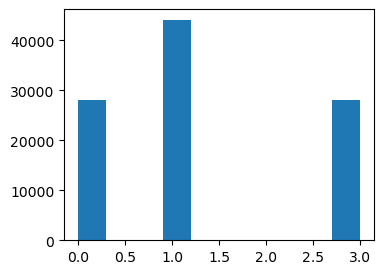

In [20]:
plt.figure(figsize=(4,3))
plt.hist(moves)

In [21]:
np.mean(np.linalg.norm(R[np.asarray(entropy_dict[1][:,1],int)],axis=2),axis=1).shape

(12,)

In [22]:
print([entropy_dict[key].shape for key in entropy_dict.keys()])

[(42, 2), (12, 2), (1, 2), (2, 2), (17, 2), (1, 2), (2, 2), (72, 2), (71892, 2), (27959, 2)]


Text(0.5, 0, 'R')

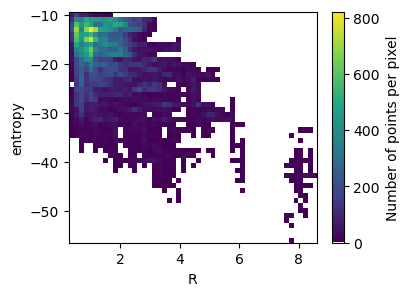

In [23]:
fig = plt.figure(figsize=(4,3))
#plt.scatter(np.mean(np.linalg.norm(R[np.asarray(entropy_dict[8][:,1],int)],axis=2),axis=1),entropy_dict[8][:,0])
ax = using_mpl_scatter_density(fig,np.mean(np.linalg.norm(R[np.asarray(entropy_dict[8][:,1],int)],axis=2),axis=1),entropy_dict[8][:,0],dpi=20)
#using_mpl_scatter_density(fig,np.mean(np.linalg.norm(R[np.asarray(entropy_dict[8][:,1],int)],axis=2),axis=1),entropy_dict[8][:,0],dpi=20,ax = ax,pos=0)
ax.set_ylabel('entropy')
ax.set_xlabel('R',rotation=0)

In [95]:
Energy = -8
Nlinker=10
print('critical energy : '+str(1.5*np.log(ell_tot/Nlinker*(np.pi/3))))
V = ((ell_tot/6)**1.5/Nlinker**0.5*3/4*np.pi)
kdiff = 1/(5*V)
Gil = gil.Gillespie(ell_tot=ell_tot,rho0=0.,BindingEnergy=Energy,kdiff=kdiff,seed=19874,sliding=False,Nlinker=Nlinker,old_gillespie=None,dimension=3)
R = np.zeros((step_tot,Nlinker-1,3),dtype=float)
S = np.zeros((step_tot),dtype=float)
moves = np.zeros((step_tot),dtype=float)
for step in range(step_tot):
    move,time = Gil.evolve()
    moves[step] = move
    R[step] = nonzero_points(Gil.get_r())
    S[step] = Gil.get_S()

critical energy : 6.976931674754073


In [96]:
S -= ell_tot*np.log(np.pi*4)
entropy_dict = linker_entropy(moves,S)

(array([38416.,     0.,     0., 23165.,     0.,     0.,     0.,     0.,
            0., 38419.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

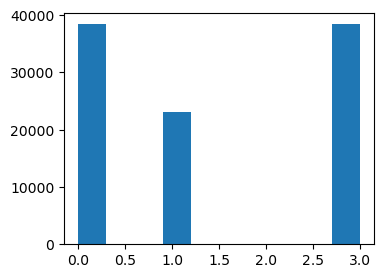

In [97]:
plt.figure(figsize=(4,3))
plt.hist(moves)

In [99]:
print([entropy_dict[key].shape for key in entropy_dict.keys()])

[(8889, 2), (6312, 2), (8345, 2), (11108, 2), (15159, 2), (18174, 2), (16680, 2), (10757, 2), (3956, 2), (620, 2)]


Text(0.5, 0, 'R')

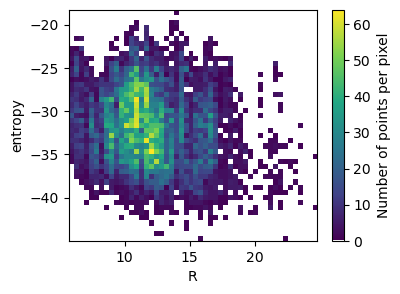

In [103]:
N= 4
fig = plt.figure(figsize=(4,3))
#plt.scatter(np.mean(np.linalg.norm(R[np.asarray(entropy_dict[8][:,1],int)],axis=2),axis=1),entropy_dict[8][:,0])
ax = using_mpl_scatter_density(fig,np.mean(np.linalg.norm(R[np.asarray(entropy_dict[N][:,1],int)],axis=2),axis=1),entropy_dict[N][:,0],dpi=20)
#using_mpl_scatter_density(fig,np.mean(np.linalg.norm(R[np.asarray(entropy_dict[8][:,1],int)],axis=2),axis=1),entropy_dict[8][:,0],dpi=20,ax = ax,pos=0)
ax.set_ylabel('entropy')
ax.set_xlabel('R',rotation=0)